In [2]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [3]:
#load the dataset
df = pd.read_csv('air-traffic-prediction/AirtrafficA4.csv')

def MonthFormatRefiner(given):
    match given:
        case 'JAN':
            return 1
        case 'FEB':
            return 2
        case 'MAR':
            return 3
        case 'APR':
            return 4
        case 'MAY':
            return 5
        case 'JUNE':
            return 6
        case 'JULY':
            return 7
        case 'AUG':
            return 8
        case 'SEP':
            return 9
        case 'OCT':
            return 10
        case 'NOV':
            return 11
        case 'DEC':
            return 12
        case _:
            return 0

def Month(given):
    return int(MonthFormatRefiner(given))

# Cleaning the months field and removing the records where the name is invalid & creating a sorted date field
df['MONTH'] = (df['MONTH'].str.strip()).apply(Month)
df1 = df[df['MONTH']!=0]
df1 = df1.sort_values(by=['YEAR', 'MONTH'], ascending=[True, True])
df1['DATE'] = pd.to_datetime(df1[['YEAR', 'MONTH']].assign(Day=1))
df1.set_index('DATE', inplace=True)

# Cleaning the numbers in various fields and filling missing values with the average of previous and next values
columns_to_clean = ['TOTAL DEPARTURES', 'HOURS FLOWN', 'KILOMETRE FLOWN', 'PASSENGERS CARRIED', 'AVAILABLE SEAT KILOMETRE (IN THOUSAND)', ' FREIGHT CARRIED (IN TONNE)', 'MAIL CARRIED (IN TONNE)']
for col in columns_to_clean:
    df1[col] = (df1[col].str.replace(r'[^0-9.]', '', regex=True)).str.strip()
    df1[col] = pd.to_numeric(df1[col], errors='coerce')
    df1[col] = df1[col].fillna(df1[col].combine_first((df1[col].shift(1) + df1[col].shift(-1))/2))

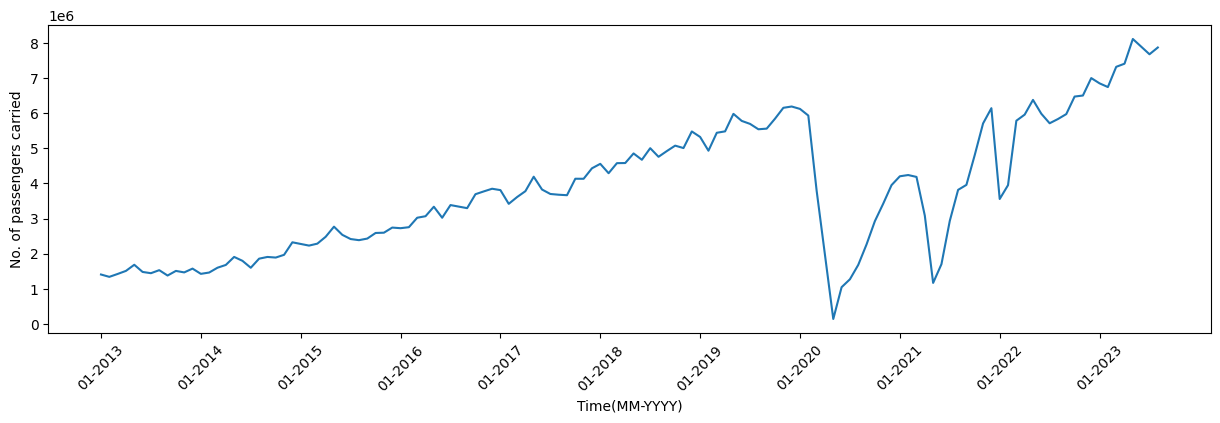

In [4]:
#visualising the data
plt.figure(figsize=(15,4))
plt.plot((np.array(df1['YEAR'])-2013)*12 + df1['MONTH'], np.array(df1['PASSENGERS CARRIED']))
ticks = np.arange(1, 132, 12)
labels = [f'0{i%12}-{2013+i//12}' for i in ticks]
plt.xticks(ticks=ticks, labels=labels, rotation=45)
plt.xlabel('Time(MM-YYYY)')
plt.ylabel('No. of passengers carried')
plt.show()

### Auto Correlation

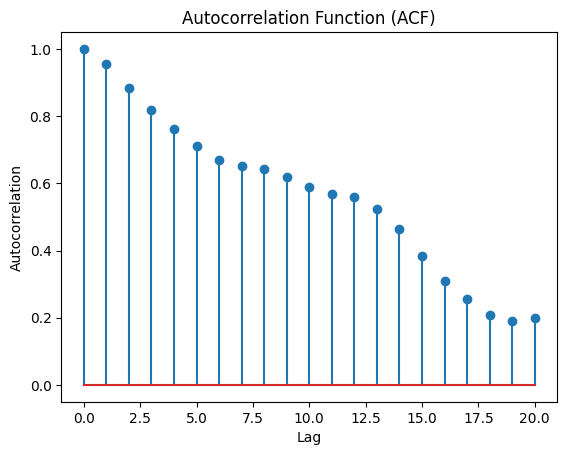

In [6]:
time_series = df1['PASSENGERS CARRIED']
lags = 20
acf_values = [time_series.autocorr(lag) for lag in range(lags + 1)]

plt.stem(range(lags + 1), acf_values)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

### ARIMA

In [5]:
def calculate_mape(actual, forecast):
    return np.mean(np.abs((actual - forecast) / (actual + 1e-10))) * 100

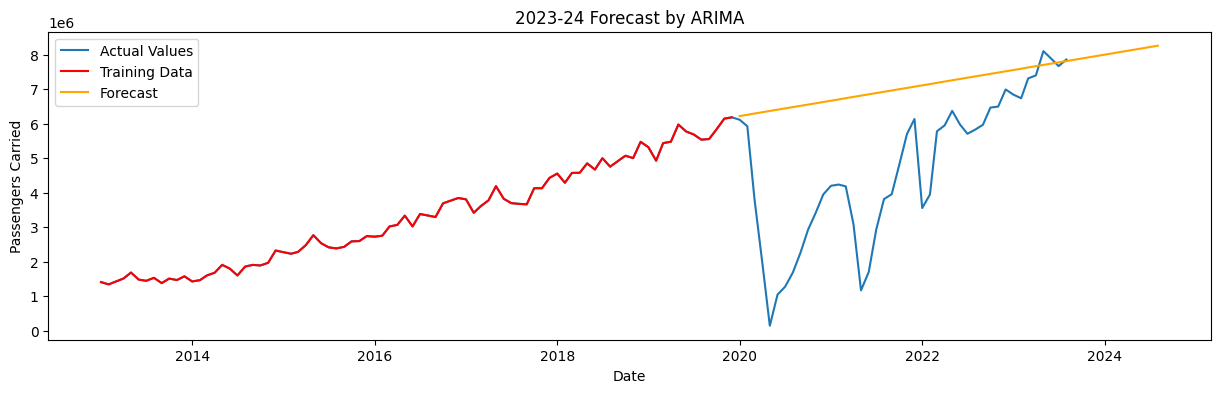

In [15]:
import warnings
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

# Ignoring the depression years 2020, 2021, 2022, 2023
data = df1[df1.index < '2020-01-01']
data = data['PASSENGERS CARRIED']
model = ARIMA(data, order=(10, 2, 20))
model_fitted = model.fit()

# Forecasting
forecast_steps = 56         # year 2020, 2021, 2022, 2023, 2024(till aug)
forecast = model_fitted.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=data.index[-1], periods=forecast_steps + 1, freq='MS')[1:]
forecast_series = forecast.predicted_mean
forecast_series.index = forecast_index

# saving to csv
forecast_df = pd.DataFrame({'PASSENGERS CARRIED': forecast_series})
forecast_df['YEAR_MONTH'] = forecast_df.index.strftime('%Y %b').str.upper()
forecast_df = forecast_df[['YEAR_MONTH', 'PASSENGERS CARRIED']]
# Selecting SEP 2023 TO AUG 2024
last_12_forecasts = forecast_df.tail(12)
last_12_forecasts.to_csv('forecast_values_last_12.csv', index=False)

plt.figure(figsize=(15, 4))
plt.plot(df1['PASSENGERS CARRIED'], label='Actual Values')
plt.plot(data, label='Training Data', color='red')
plt.plot(forecast_series, label='Forecast', color='orange')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Passengers Carried')
plt.title('2023-24 Forecast by ARIMA')
plt.show()
